# 补充属性

## 语义难度

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("data/mcm_processed_data.csv")
df.head()

## 语义领居数量

In [ ]:
def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            # 后面是向量
            vec = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vec
    print(f"Loaded {len(embeddings)} word vectors.")
    return embeddings

glove_path = "data/glove.6B/glove.6B.300d.txt"  # 替换为你的路径
embeddings = load_glove_embeddings(glove_path)

In [ ]:
wordle_words = df['word'].tolist()

In [ ]:
# 为每个单词取词向量
def get_vector(word, embeddings):
    w = word.lower()
    if w in embeddings:
        return embeddings[w]
    else:
        return None  # OOV 处理留给后面

word_vectors = {}
oov_words = []

for w in wordle_words:
    vec = get_vector(w, embeddings)
    if vec is not None:
        word_vectors[w] = vec
    else:
        oov_words.append(w)

print("OOV words:", oov_words)
print("Have vectors for:", len(word_vectors), "words")

In [ ]:
# 定义余弦相似度
def cosine_sim(vec1, vec2):
    num = np.dot(vec1, vec2)
    denom = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    if denom == 0.0:
        return 0.0
    return num / denom

In [ ]:
tau = 0.5

words = list(word_vectors.keys())
vecs = [word_vectors[w] for w in words if len(w) == 5]

glove_words = list(embeddings.keys())
glove_vecs = [embeddings[w.lower()] for w in glove_words if len(w) == 5]

In [ ]:
len(vecs)

In [ ]:
semantic_neighbors_count = {}

from tqdm import tqdm

for i, w in enumerate(tqdm(words)):
    v_w = vecs[i]
    count = 0
    for word, glove_vecs in embeddings.items():
        if len(word) != 5:
            continue
        if w == word:
            continue
        sim = cosine_sim(v_w, glove_vecs)
        if sim >= tau:
            count += 1
    semantic_neighbors_count[w] = count


In [ ]:
df["semantic_neighbors_count"] = df["word"].map(semantic_neighbors_count.get)

In [ ]:
from heapq import nlargest

k = 10
semantic_density = {}

for i, w in enumerate(tqdm(words)):
    v_w = vecs[i]
    sims = []
    for word, glove_vecs in embeddings.items():
        if len(word) != 5:
            continue
        if w == word:
            continue
        sims.append(cosine_sim(v_w, glove_vecs))
    topk = nlargest(k, sims)
    semantic_density[w] = float(sum(topk)) / k

In [ ]:
df['semantic_density'] = df['word'].map(semantic_density.get)

In [ ]:
neighbors_log = np.log1p(df['semantic_neighbors_count'])
neighbors_z = (neighbors_log - neighbors_log.mean()) / neighbors_log.std()
density_z = (df['semantic_density'] - df['semantic_density'].mean()) / df['semantic_density'].std()
df['semantic_difficulty'] = (0.5 * neighbors_z + 0.5 * density_z)

In [ ]:
df.to_csv("data/mcm_processed_data.csv", index=False)

## 词频难度

In [ ]:
df = pd.read_excel("data/mcm_processed_data.csv.xlsx")
df.head()

In [ ]:
dt = pd.read_excel("data/SUBTLEX-US frequency list with PoS and Zipf information.xlsx")
dt.head()

In [ ]:
# 假设 df 的列是 'word'，dt 的列是 'Word' 和 'Zipf-value'
df = df.merge(
    dt[['Word', 'Zipf-value']],
    left_on='word',
    right_on='Word',
    how='left'
)

# 如果不需要保留 'Word' 这一列，可以删掉
df = df.drop(columns=['Word'])

In [ ]:
neighbors_log = np.log1p(df['semantic_neighbors_count'])
neighbors_z = (neighbors_log - neighbors_log.mean()) / neighbors_log.std()
density_z = (df['semantic_density'] - df['semantic_density'].mean()) / df['semantic_density'].std()
df['semantic_difficulty'] = -(0.5 * neighbors_z + 0.5 * density_z)

In [ ]:
df.head()

In [ ]:
df.to_excel("data/Copydata_with_features.xlsx", index=False)

## 汉明距离

In [ ]:
with open ('data/allowed.txt', 'r') as f:
    allowed = f.read().splitlines()
allowed = [word.lower().strip() for word in allowed]
print(allowed)

In [ ]:
def hamming_distance(w1, w2):
    # 定义汉明距离函数
    return sum(c1 != c2 for c1, c2 in zip(w1, w2))

In [ ]:
neighbors = {}

for w in df['word'].tolist():
    cnt = 0
    for v in allowed:
        if w != v and hamming_distance(w, v) == 1:
            cnt += 1

    neighbors[w] = cnt

print(neighbors)

In [ ]:
# 将 neighbors 字典映射到 df，生成一列
df['hamming_neighbors'] = df['word'].map(neighbors)
df.to_csv('data/mcm_processed_data.csv', index=False)

## 规则熵

## 位置熵

In [ ]:
import pandas as pd
df = pd.read_csv("data/mcm_processed_data.csv", low_memory=False)
df.head()

In [ ]:
from wordfreq import top_n_list
top5000 = top_n_list("en", 500000)

# 筛选长度为 5 的
words_5 = [w for w in top5000 if len(w) == 5 if "'" not in w][:20000]
print(len(words_5))

In [ ]:
pos_probs = {}
for word in words_5:
    for pos, letter in enumerate(word):
        pos_probs.setdefault(pos, {}).setdefault(letter, 0)
        pos_probs[pos][letter] += 1

In [ ]:
# 转换为概率
for pos, dic in pos_probs.items():
    total = sum(dic.values())
    for letter, prob in dic.items():
        pos_probs[pos][letter] = prob / total

In [ ]:
# 2. 计算某个词的信息量 I(w)
import math
def word_information(w, pos_probs, log_base=2):
    w = w.lower()
    info = 0.0
    log = math.log2 if log_base == 2 else math.log
    for i, ch in enumerate(w):
        p = pos_probs[i].get(ch, 1e-8)  # 防止极小概率为0
        info += -log(p)
    return info

In [ ]:
# 将 neighbors 字典映射到 df，生成一列
df['position_self_information'] = df['word'].map(lambda x : word_information(x, pos_probs))
df.to_csv('data/mcm_processed_data.csv', index=False)

## 位置熵（2字母）

In [ ]:
pos_probs = {}
for word in words_5:
    
    pos_probs.setdefault((0, 2), {}).setdefault(word[0:2], 0)
    pos_probs[(0, 2)][word[0:2]] += 1
    
    pos_probs.setdefault((1, 3), {}).setdefault(word[1:3], 0)
    pos_probs[(1, 3)][word[1:3]] += 1
    
    pos_probs.setdefault((2, 4), {}).setdefault(word[2:4], 0)
    pos_probs[(2, 4)][word[2:4]] += 1
    
    pos_probs.setdefault((3, 5), {}).setdefault(word[3:5], 0)
    pos_probs[(3, 5)][word[3:5]] += 1

In [ ]:
# 2. 计算某个词的信息量 I(w)
import math
def word_information_2(w, pos_probs, log_base=2):
    w = w.lower()
    info = 0.0
    log = math.log2 if log_base == 2 else math.log
    
    p  = pos_probs[(0, 2)].get(w[0:2], 1e-8)
    info += -log(p)
    
    p = pos_probs[(1, 3)].get(w[1:3], 1e-8)
    info += -log(p)
    
    p = pos_probs[(2, 4)].get(w[2:4], 1e-8)
    info += -log(p)
    
    p = pos_probs[(3, 5)].get(w[3:5], 1e-8)
    info += -log(p)

    return info

In [ ]:
# 将 neighbors 字典映射到 df，生成一列
df['position_self_information_2_letters'] = df['word'].map(lambda x : word_information_2(x, pos_probs))
df.to_csv('data/mcm_processed_data.csv', index=False)

## Lasso回归分析 - 变量重要性

In [2]:
# 加载数据
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
df = pd.read_csv("data/mcm_processed_data.csv")

# 定义需要排除的列
exclude_cols = ['date', 'contest_number', 'word', 'number_of_reported_results', 'number_in_hard_mode',
                'sum', 'autoencoder_value', 'expected_attempts',
                '1_try', '2_tries', '3_tries', '4_tries', '5_tries', '6_tries', '7_or_more_tries_x']
random_try_cols = ['1_try_simulate_random', '2_try_simulate_random', '3_try_simulate_random',
                '4_try_simulate_random', '5_try_simulate_random', '6_try_simulate_random',
                '7_try_simulate_random']
freq_try_cols = ['1_try_simulate_freq', '2_try_simulate_freq', 
                 '3_try_simulate_freq', '4_try_simulate_freq', '5_try_simulate_freq', 
                 '6_try_simulate_freq', '7_try_simulate_freq']
entropy_try_cols = ['1_try_simulate_entropy', '2_try_simulate_entropy', 
                    '3_try_simulate_entropy', '4_try_simulate_entropy', '5_try_simulate_entropy', 
                    '6_try_simulate_entropy', '7_try_simulate_entropy']
rl_try_low_training_cols = [
    'rl_1_try_low_training','rl_2_try_low_training','rl_3_try_low_training',
    'rl_4_try_low_training','rl_5_try_low_training','rl_6_try_low_training',
    'rl_7_try_low_training'
]
rl_try_high_training_cols = [
    'rl_1_try_high_training','rl_2_try_high_training','rl_3_try_high_training',
    'rl_4_try_high_training','rl_5_try_high_training','rl_6_try_high_training',
    'rl_7_try_high_training'
]
exclude_cols.extend(random_try_cols)
exclude_cols.extend(freq_try_cols)
exclude_cols.extend(entropy_try_cols)
exclude_cols.extend(rl_try_low_training_cols)
exclude_cols.extend(rl_try_high_training_cols)
# 选择特征列
feature_cols = [col for col in df.columns if col not in exclude_cols]
print("特征变量:", feature_cols)
print(f"\n共 {len(feature_cols)} 个特征变量")

特征变量: ['num_rare_letters', 'starts_with_vowel', 'ends_with_vowel', 'num_consonants', 'contains_y', 'has_double_letter', 'max_consecutive_vowels', 'max_consecutive_consonants', 'scrabble_score', 'letter_entropy', 'position_rarity', 'keyboard_distance', 'hamming_neighbors', 'has_common_suffix', 'has_common_prefix', 'letter_freq_mean', 'letter_freq_min', 'positional_freq_mean', 'positional_freq_min', 'semantic_neighbors_count', 'semantic_density', 'Zipf-value', 'semantic_difficulty', 'position_self_information', 'positional_fit', 'letter_commonness', 'position_self_information_2_letters', 'mean_simulate_random', 'mean_simulate_freq', 'mean_simulate_entropy', 'rl_expected_steps_low_training', 'rl_expected_steps_high_training']

共 32 个特征变量


In [3]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# 准备数据
X = df[feature_cols].copy()
y = df['autoencoder_value'].copy()

# 检查目标变量
print("目标变量统计:")
print(y.describe())
print(f"\n缺失值数量: {y.isna().sum()}")

# 处理缺失值
X = X.fillna(X.median())
y = y.fillna(y.median())

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n特征矩阵形状: {X_scaled.shape}")
print(f"目标变量形状: {y.shape}")

目标变量统计:
count    358.000000
mean      -0.598737
std        0.457796
min       -1.674467
25%       -0.889708
50%       -0.642736
75%       -0.359731
max        2.255668
Name: autoencoder_value, dtype: float64

缺失值数量: 0

特征矩阵形状: (358, 32)
目标变量形状: (358,)


In [4]:
# 使用交叉验证选择最优的alpha参数
alphas_to_try = np.logspace(-8, -1, 100)
lasso_cv = LassoCV(alphas=alphas_to_try, cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_scaled, y)

print(f"交叉验证选择的最优 alpha: {lasso_cv.alpha_:.8f}")
print(f"R² 得分 (最优alpha): {lasso_cv.score(X_scaled, y):.4f}")

# 测试不同alpha值的效果
print("\n不同alpha值的模型效果:")
for alpha in [0.0001, 0.001, 0.005, 0.007, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1]:
    lasso_test = Lasso(alpha=alpha, max_iter=10000)
    lasso_test.fit(X_scaled, y)
    n_nonzero = (lasso_test.coef_ != 0).sum()
    r2 = lasso_test.score(X_scaled, y)
    print(f"  alpha={alpha:.4f}: R²={r2:.4f}, 非零系数={n_nonzero}")

# 选择一个能保留足够特征的alpha进行分析
analysis_alpha = lasso_cv.alpha_
lasso_final = Lasso(alpha=analysis_alpha, max_iter=10000)
lasso_final.fit(X_scaled, y)
print(f"\n最终选择 alpha={analysis_alpha} 进行变量重要性分析")
print(f"R² 得分: {lasso_final.score(X_scaled, y):.4f}")
print(f"非零系数数量: {(lasso_final.coef_ != 0).sum()}/{len(feature_cols)}")

交叉验证选择的最优 alpha: 0.00869749
R² 得分 (最优alpha): 0.6922

不同alpha值的模型效果:
  alpha=0.0001: R²=0.7062, 非零系数=31
  alpha=0.0010: R²=0.7056, 非零系数=28
  alpha=0.0050: R²=0.6975, 非零系数=21
  alpha=0.0070: R²=0.6948, 非零系数=18
  alpha=0.0080: R²=0.6934, 非零系数=18
  alpha=0.0100: R²=0.6898, 非零系数=18
  alpha=0.0200: R²=0.6725, 非零系数=15
  alpha=0.0300: R²=0.6542, 非零系数=14
  alpha=0.0400: R²=0.6373, 非零系数=12
  alpha=0.0500: R²=0.6160, 非零系数=12
  alpha=0.0800: R²=0.5319, 非零系数=8
  alpha=0.1000: R²=0.4739, 非零系数=6

最终选择 alpha=0.008697490026177835 进行变量重要性分析
R² 得分: 0.6922
非零系数数量: 18/32


In [5]:
# 获取特征系数并排序
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lasso_final.coef_,
    'abs_coefficient': np.abs(lasso_final.coef_)
}).sort_values('abs_coefficient', ascending=False)

# 显示所有特征的重要性
print("=" * 60)
print(f"Lasso回归特征重要性排序 (alpha={analysis_alpha})")
print("=" * 60)
for i, row in coef_df.iterrows():
    status = "✓" if row['coefficient'] != 0 else "✗"
    print(f"{status} {row['feature']:30s} : {row['coefficient']:+.6f}")

print("\n" + "=" * 60)
print(f"非零系数特征数: {(coef_df['coefficient'] != 0).sum()} / {len(feature_cols)}")
print("=" * 60)

Lasso回归特征重要性排序 (alpha=0.008697490026177835)
✓ mean_simulate_freq             : +0.173980
✓ letter_entropy                 : -0.090701
✓ mean_simulate_random           : +0.075532
✓ has_common_suffix              : +0.063364
✓ letter_freq_mean               : -0.058364
✓ position_self_information_2_letters : +0.051315
✓ letter_freq_min                : -0.049545
✓ positional_freq_mean           : -0.039617
✓ mean_simulate_entropy          : +0.036771
✓ num_consonants                 : -0.029464
✓ rl_expected_steps_high_training : +0.026532
✓ rl_expected_steps_low_training : +0.025496
✓ positional_freq_min            : -0.024182
✓ keyboard_distance              : -0.023447
✓ max_consecutive_vowels         : -0.014517
✓ contains_y                     : +0.013484
✓ semantic_neighbors_count       : -0.006475
✓ has_double_letter              : -0.003737
✗ position_self_information      : -0.000000
✗ ends_with_vowel                : +0.000000
✗ letter_commonness              : -0.000000
✗ pos

In [8]:
# 定义特征类别（与Cell 47保持一致）
feature_categories = {
    '基础特征': ['num_rare_letters',  'num_consonants', 
                 'contains_y', 'has_double_letter', 'max_consecutive_vowels', 'max_consecutive_consonants',
                 'scrabble_score', 'hamming_neighbors', 'has_common_suffix', 'has_common_prefix'],
    '字母频率特征': ['letter_freq_mean', 'letter_freq_min', 'letter_commonness', 'Zipf-value'],
    '位置特征': ['position_rarity', 'positional_freq_mean', 'positional_freq_min', 'positional_fit'
             'starts_with_vowel', 'ends_with_vowel'],
    '键盘距离特征': ['keyboard_distance'],
    '语义特征': ['semantic_neighbors_count', 'semantic_density', 'semantic_difficulty'],
    '仿真模拟特征': ['mean_simulate_random', '1_try_simulate_random', '2_try_simulate_random',
                     '3_try_simulate_random', '4_try_simulate_random', '5_try_simulate_random',
                     '6_try_simulate_random', '7_try_simulate_random', 'mean_simulate_freq', '1_try_simulate_freq', '2_try_simulate_freq',
                     '3_try_simulate_freq', '4_try_simulate_freq', '5_try_simulate_freq',
                     '6_try_simulate_freq', '7_try_simulate_freq', 'mean_simulate_entropy', '1_try_simulate_entropy', '2_try_simulate_entropy',
                   '3_try_simulate_entropy', '4_try_simulate_entropy', '5_try_simulate_entropy',
                   '6_try_simulate_entropy', '7_try_simulate_entropy'],
    '熵特征': ['letter_entropy', 'position_self_information_2_letters', 'position_self_information'],
    '强化学习特征': ['rl_expected_steps_low_training', 'rl_1_try_low_training', 
               'rl_2_try_low_training', 'rl_3_try_low_training', 'rl_4_try_low_training', 
               'rl_5_try_low_training', 'rl_6_try_low_training', 'rl_7_try_low_training',
               'rl_1_try_high_training','rl_2_try_high_training','rl_3_try_high_training',
                'rl_4_try_high_training','rl_5_try_high_training','rl_6_try_high_training',
                'rl_7_try_high_training', 'rl_expected_steps_high_training']
}

# 为每个类别分配颜色和标记
category_colors = {
    '基础特征': '#1f77b4',
    '字母频率特征': '#ff7f0e', 
    '位置特征': '#2ca02c',
    '键盘距离特征': '#d62728',
    '语义特征': '#9467bd',
    '仿真模拟特征': '#8c564b',
    '熵特征': '#7f7f7f',
    '强化学习特征': '#bcbd22', 
    # '频率模拟特征': '#e377c2',
}
# 为不同类别使用不同的柱状图样式
category_hatches = {
    '基础特征': 'ooo',
    '字母频率特征': '///',
    '位置特征': '\\\\\\',
    '键盘距离特征': '|||',
    '语义特征': '---',
    '方针模拟特征': '+++',
    '熵特征': '...',
    '强化学习特征': '***',
    '其他': 'xxx',
    # '频率模拟特征': ''
}

# 为每个类别分配线条样式和颜色
category_styles = {
    '基础特征': {'color': '#1f77b4', 'linestyle': '-', 'linewidth': 2.0},
    '字母频率特征': {'color': '#ff7f0e', 'linestyle': '--', 'linewidth': 2.0},
    '位置特征': {'color': '#2ca02c', 'linestyle': '-.', 'linewidth': 2.0},
    '键盘距离特征': {'color': '#d62728', 'linestyle': ':', 'linewidth': 2.5},
    '语义特征': {'color': '#9467bd', 'linestyle': '-', 'linewidth': 1.5},
    '仿真模拟特征': {'color': '#8c564b', 'linestyle': '--', 'linewidth': 1.5},
    '熵特征': {'color': '#7f7f7f', 'linestyle': ':', 'linewidth': 1.5},
    '强化学习特征': {'color': '#bcbd22', 'linestyle': '-', 'linewidth': 2.5},
    # '频率模拟特征': {'color': '#e377c2', 'linestyle': '-.', 'linewidth': 1.5},
}

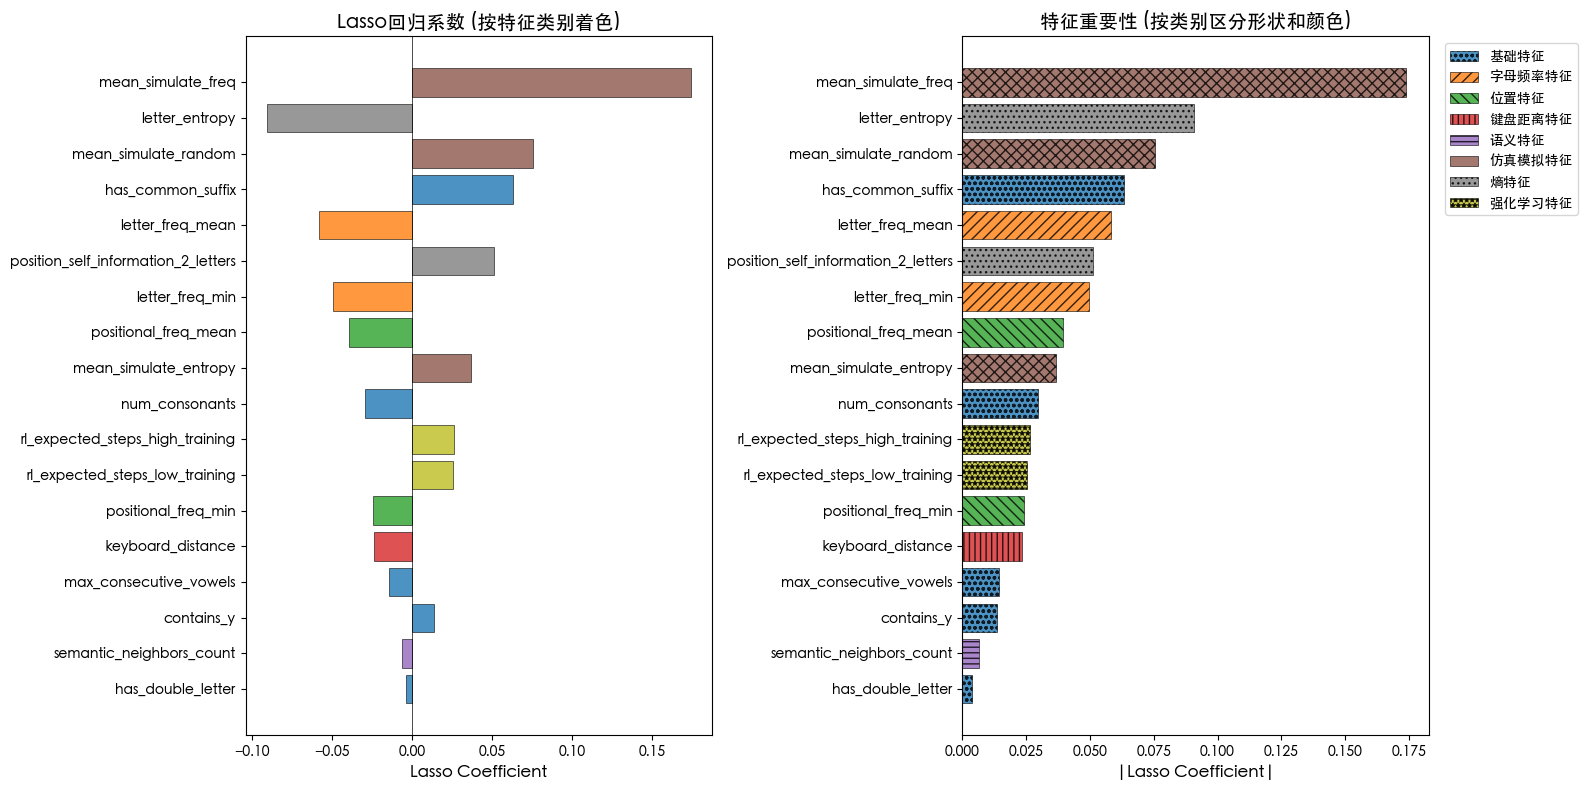


图例说明:
- 颜色区分特征类别
- 填充图案(hatch)进一步区分类别
- 绿色边框=正相关系数, 红色边框=负相关系数

特征类别统计:
  基础特征: 5 个特征
  仿真模拟特征: 3 个特征
  熵特征: 2 个特征
  字母频率特征: 2 个特征
  位置特征: 2 个特征
  强化学习特征: 2 个特征
  键盘距离特征: 1 个特征
  语义特征: 1 个特征


In [9]:
# 可视化特征重要性
plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 定义特征类别（与Cell 47保持一致）

# 只显示非零系数的特征
nonzero_df = coef_df[coef_df['coefficient'] != 0].copy()

# 为每个特征分配类别和颜色
def get_feature_category(feature):
    for category, features in feature_categories.items():
        if feature in features:
            return category
    return '其他'

nonzero_df['category'] = nonzero_df['feature'].apply(get_feature_category)
nonzero_df['color'] = nonzero_df['category'].map(category_colors)

# 图1: 按系数值排序的条形图（使用不同颜色区分类别）
ax1 = axes[0]
colors1 = ['green' if x > 0 else 'red' for x in nonzero_df['coefficient']]
bars1 = ax1.barh(range(len(nonzero_df)), nonzero_df['coefficient'], 
                 color=nonzero_df['color'], alpha=0.8, edgecolor='black', linewidth=0.5)

ax1.set_yticks(range(len(nonzero_df)))
ax1.set_yticklabels(nonzero_df['feature'])
ax1.set_xlabel('Lasso Coefficient', fontsize=12)
ax1.set_title('Lasso回归系数 (按特征类别着色)', fontsize=14)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax1.invert_yaxis()

# 图2: 按绝对值排序的条形图（使用不同形状区分类别）
ax2 = axes[1]
sorted_by_abs = nonzero_df.sort_values('abs_coefficient', ascending=True)



# 绘制柱状图
y_positions = range(len(sorted_by_abs))
for i, (idx, row) in enumerate(sorted_by_abs.iterrows()):
    category = row['category']
    color = row['color']
    hatch = category_hatches.get(category, 'xxx')
    
    ax2.barh(i, row['abs_coefficient'], 
             color=color, alpha=0.8, 
             hatch=hatch, edgecolor='black', linewidth=0.5)

ax2.set_yticks(y_positions)
ax2.set_yticklabels(sorted_by_abs['feature'])
ax2.set_xlabel('|Lasso Coefficient|', fontsize=12)
ax2.set_title('特征重要性 (按类别区分形状和颜色)', fontsize=14)

# 添加图例
legend_elements = []
for category, color in category_colors.items():
    if category in sorted_by_abs['category'].values:
        hatch = category_hatches.get(category, '')
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.8, 
                         hatch=hatch, edgecolor='black', linewidth=0.5, label=category)
        )

ax2.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('data/lasso_feature_importance_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印类别统计
print("\n图例说明:")
print("- 颜色区分特征类别")
print("- 填充图案(hatch)进一步区分类别")
print("- 绿色边框=正相关系数, 红色边框=负相关系数")
print("\n特征类别统计:")
category_counts = nonzero_df['category'].value_counts()
for category, count in category_counts.items():
    print(f"  {category}: {count} 个特征")

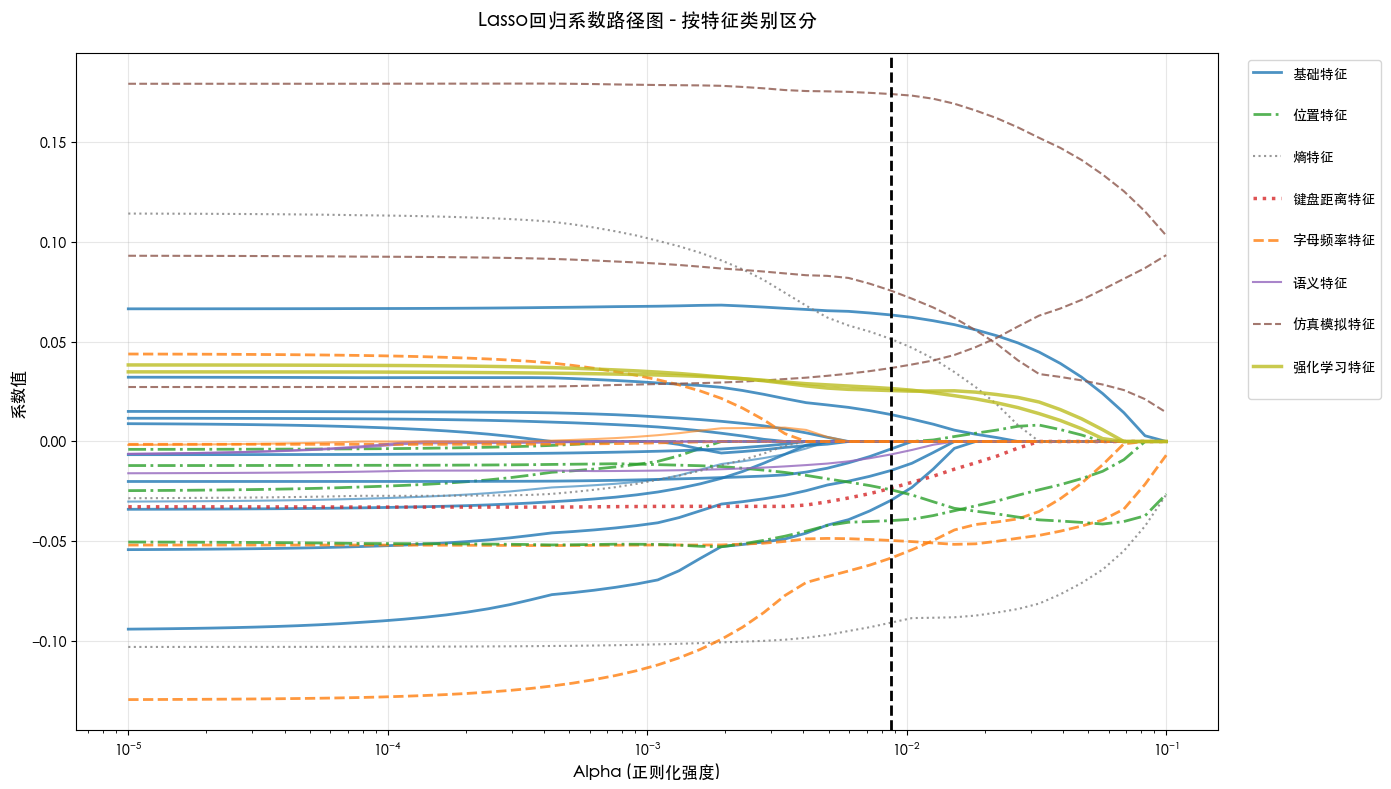


特征类别统计:
  基础特征: 10 个特征
  字母频率特征: 4 个特征
  位置特征: 4 个特征
  键盘距离特征: 1 个特征
  语义特征: 3 个特征
  仿真模拟特征: 3 个特征
  熵特征: 3 个特征
  强化学习特征: 2 个特征


In [10]:
# 不同alpha值下的系数路径图
alphas = np.logspace(-5, -1, 50)
coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)



# 绘制系数路径
plt.figure(figsize=(14, 8))

# 为每个特征分配到对应的类别
for i, feature in enumerate(feature_cols):
    # 找到特征所属的类别
    category = None
    for cat_name, features in feature_categories.items():
        if feature in features:
            category = cat_name
            break
    
    if category:
        style = category_styles[category]
        plt.plot(alphas, coefs[:, i], label=f"{feature} ({category})", 
                color=style['color'], linestyle=style['linestyle'], 
                linewidth=style['linewidth'], alpha=0.8)
    else:
        # 未分类的特征使用默认样式
        plt.plot(alphas, coefs[:, i], label=feature, linewidth=1.5, alpha=0.6)

plt.xscale('log')
plt.xlabel('Alpha (正则化强度)', fontsize=12)
plt.ylabel('系数值', fontsize=12)
plt.title('Lasso回归系数路径图 - 按特征类别区分', fontsize=14, pad=20)
plt.axvline(x=analysis_alpha, color='black', linestyle='--', label=f'选定alpha={analysis_alpha:.6f}', linewidth=2)

# 创建图例，按类别分组
handles, labels = plt.gca().get_legend_handles_labels()
# 按类别重新组织图例
category_handles = {}
for handle, label in zip(handles, labels):
    # 提取类别名
    if '(' in label and ')' in label:
        category = label.split('(')[-1].strip(')')
        if category not in category_handles:
            category_handles[category] = []
        category_handles[category].append(handle)

# 创建新的图例
legend_elements = []
for category, handles_list in category_handles.items():
    # 使用第一个handle的颜色和样式
    if handles_list:
        legend_elements.append(handles_list[0])
        legend_elements.append(plt.Line2D([0], [0], color='white', linewidth=0))  # 空白分隔

plt.legend(legend_elements, 
           [f"{cat}" if i % 2 == 0 else "" for i, cat in enumerate(sum([[k] * 2 for k in category_handles.keys()], []))],
           bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, frameon=True)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/lasso_coefficient_path_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印类别统计
print("\n特征类别统计:")
for category, features in feature_categories.items():
    count = len([f for f in features if f in feature_cols])
    if count > 0:
        print(f"  {category}: {count} 个特征")

In [13]:
# 计算所有构建指标的皮尔森相关性
import seaborn as sns
import matplotlib.pyplot as plt

# 排除数值特征列（排除非数值列和ID列）
exclude_cols = ['date', 'contest_number', 'word', 'number_of_reported_results', 'number_in_hard_mode',
                'sum', '1_try_simulate_random', '2_try_simulate_random', '3_try_simulate_random',
                '4_try_simulate_random', '5_try_simulate_random', '6_try_simulate_random',
                '7_try_simulate_random','1_try_simulate_freq', '2_try_simulate_freq', '3_try_simulate_freq', 
                '4_try_simulate_freq', '5_try_simulate_freq', '6_try_simulate_freq', '7_try_simulate_freq',
                '1_try', '2_tries', '3_tries', '4_tries', '5_tries', '6_tries', '7_or_more_tries_x', 
                '1_try_simulate_entropy', '2_try_simulate_entropy', '3_try_simulate_entropy',
                '4_try_simulate_entropy', '5_try_simulate_entropy', '6_try_simulate_entropy', '7_try_simulate_entropy',
                'rl_1_try_low_training','rl_2_try_low_training','rl_3_try_low_training',
                'rl_4_try_low_training','rl_5_try_low_training','rl_6_try_low_training',
                'rl_7_try_low_training', 'rl_1_try_high_training','rl_2_try_high_training','rl_3_try_high_training',
                'rl_4_try_high_training','rl_5_try_high_training','rl_6_try_high_training',
                'rl_7_try_high_training'
                # '1_try', '2_tries', '3_tries', '4_tries', '5_tries', '6_tries', '7_or_more_tries_x', 
                ]
numeric_features = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['float64', 'int64']]

# # 选择数值特征列
# include_cols = ['autoencoder_value','1_try_simulate_random', '2_try_simulate_random', '3_try_simulate_random',
#                 '4_try_simulate_random', '5_try_simulate_random', '6_try_simulate_random',
#                 '7_try_simulate_random','1_try_simulate_freq', '2_try_simulate_freq', '3_try_simulate_freq', 
#                 '4_try_simulate_freq', '5_try_simulate_freq', '6_try_simulate_freq', '7_try_simulate_freq',
#                 'expected_attempts','mean_simulate_random', 'mean_simulate_freq',
#                 '1_try', '2_tries', '3_tries', '4_tries', '5_tries', '6_tries', '7_or_more_tries_x', 
#                 'rl_expected_steps','1_try_simulate_entropy', '2_try_simulate_entropy', '3_try_simulate_entropy',
#                 '4_try_simulate_entropy', '5_try_simulate_entropy', '6_try_simulate_entropy', '7_try_simulate_entropy',
#                 'mean_simulate_entropy']
# numeric_features = [col for col in df.columns if col in include_cols and df[col].dtype in ['float64', 'int64']]
print(f"用于相关性分析的数值特征 ({len(numeric_features)} 个):")
for i, col in enumerate(numeric_features, 1):
    print(f"{i:2d}. {col}")

# 计算相关性矩阵
correlation_matrix = df[numeric_features].corr()

print(f"\n相关性矩阵形状: {correlation_matrix.shape}")
print("\n相关性矩阵前5x5:")
print(correlation_matrix.iloc[:5, :5].round(3))

用于相关性分析的数值特征 (34 个):
 1. num_rare_letters
 2. starts_with_vowel
 3. ends_with_vowel
 4. num_consonants
 5. contains_y
 6. has_double_letter
 7. max_consecutive_vowels
 8. max_consecutive_consonants
 9. scrabble_score
10. letter_entropy
11. position_rarity
12. keyboard_distance
13. hamming_neighbors
14. has_common_suffix
15. has_common_prefix
16. letter_freq_mean
17. letter_freq_min
18. positional_freq_mean
19. positional_freq_min
20. semantic_neighbors_count
21. semantic_density
22. Zipf-value
23. autoencoder_value
24. expected_attempts
25. semantic_difficulty
26. position_self_information
27. positional_fit
28. letter_commonness
29. position_self_information_2_letters
30. mean_simulate_random
31. mean_simulate_freq
32. mean_simulate_entropy
33. rl_expected_steps_low_training
34. rl_expected_steps_high_training

相关性矩阵形状: (34, 34)

相关性矩阵前5x5:
                   num_rare_letters  starts_with_vowel  ends_with_vowel  \
num_rare_letters              1.000             -0.010            0.061

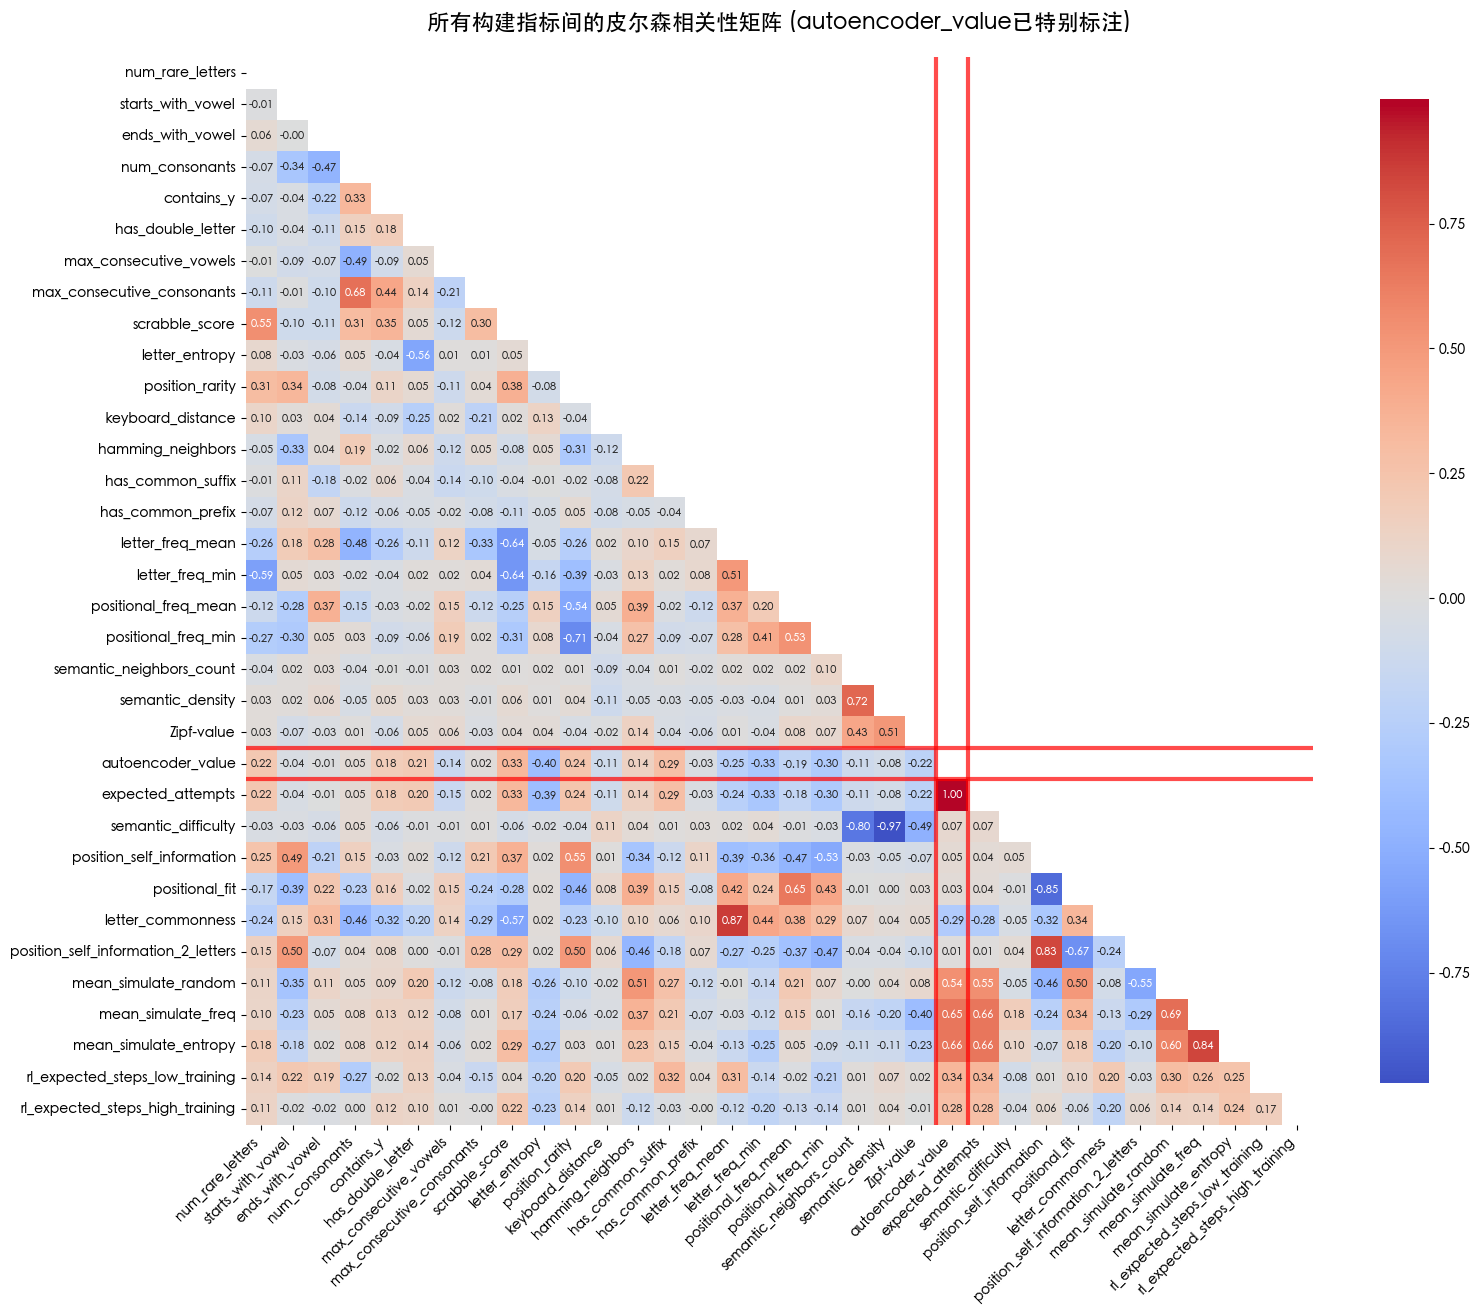

相关性热力图已保存到: data/correlation_heatmap_highlighted.png
autoencoder_value位于第23行/列（从1开始计数）


In [14]:
# 创建相关性热力图
plt.figure(figsize=(16, 14))

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 找到autoencoder_value的索引位置
autoencoder_idx = list(correlation_matrix.columns).index('autoencoder_value')

# 创建热力图
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 只显示下三角

# 创建自定义的颜色映射，为autoencoder_value行/列添加特殊颜色
cmap = plt.cm.coolwarm

# 绘制热力图
sns.heatmap(correlation_matrix, 
            annot=True,
            mask=mask,
            cmap=cmap, 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": 0.8},
            annot_kws={'size': 8})

# 为autoencoder_value的行和列添加特殊标注
ax = plt.gca()

# 高亮autoencoder_value行（水平线）
ax.axhline(y=autoencoder_idx + 1, color='red', linewidth=3, alpha=0.7)
ax.axhline(y=autoencoder_idx, color='red', linewidth=3, alpha=0.7)

# 高亮autoencoder_value列（垂直线）
ax.axvline(x=autoencoder_idx + 1, color='red', linewidth=3, alpha=0.7)
ax.axvline(x=autoencoder_idx, color='red', linewidth=3, alpha=0.7)


plt.title('所有构建指标间的皮尔森相关性矩阵 (autoencoder_value已特别标注)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# 保存图片
plt.savefig('data/correlation_heatmap_highlighted.png', dpi=600, bbox_inches='tight')
plt.show()

print("相关性热力图已保存到: data/correlation_heatmap_highlighted.png")
print(f"autoencoder_value位于第{autoencoder_idx + 1}行/列（从1开始计数）")

In [ ]:
# 找出高相关性特征对
print("=" * 80)
print("高相关性特征对分析 (|r| ≥ 0.5)")
print("=" * 80)

high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) >= 0.5:  # 阈值设为0.5
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feature1, feature2, corr_value))

# 按相关性绝对值排序
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"找到 {len(high_corr_pairs)} 对高相关性特征:\n")

for feature1, feature2, corr_value in high_corr_pairs:
    direction = "正相关" if corr_value > 0 else "负相关"
    print(f"{feature1:30s} ↔ {feature2:30s}: {corr_value:+.3f} ({direction})")

# 特别关注语义相关指标
print("\n" + "=" * 80)
print("语义相关指标与其他特征的相关性:")
print("=" * 80)

semantic_features = ['semantic_neighbors_count', 'semantic_density', 'semantic_difficulty', 'Zipf-value']

for feature in semantic_features:
    if feature in correlation_matrix.columns:
        correlations = correlation_matrix[feature].sort_values(key=abs, ascending=False)
        print(f"\n{feature} 的相关性排序 (前10个):")
        for other_feature, corr_value in correlations.head(10).items():
            if other_feature != feature:
                direction = "正相关" if corr_value > 0 else "负相关"
                print(f"  {other_feature:30s}: {corr_value:+.3f} ({direction})")

In [ ]:
# 保存相关性分析结果
import os

# 创建输出目录
os.makedirs('data', exist_ok=True)

# 保存相关性矩阵到Excel
correlation_matrix.to_excel('data/correlation_matrix.xlsx')
print("相关性矩阵已保存到: data/correlation_matrix.xlsx")

# 保存高相关性对到文本文件
with open('data/high_correlation_pairs.txt', 'w', encoding='utf-8') as f:
    f.write("高相关性特征对分析 (|r| ≥ 0.5)\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"找到 {len(high_corr_pairs)} 对高相关性特征:\n\n")
    
    for feature1, feature2, corr_value in high_corr_pairs:
        direction = "正相关" if corr_value > 0 else "负相关"
        f.write(f"{feature1:30s} ↔ {feature2:30s}: {corr_value:+.3f} ({direction})\n")
    
    f.write("\n" + "=" * 80 + "\n")
    f.write("语义相关指标与其他特征的相关性:\n")
    f.write("=" * 80 + "\n\n")
    
    for feature in semantic_features:
        if feature in correlation_matrix.columns:
            correlations = correlation_matrix[feature].sort_values(key=abs, ascending=False)
            f.write(f"\n{feature} 的相关性排序 (前10个):\n")
            for other_feature, corr_value in correlations.head(10).items():
                if other_feature != feature:
                    direction = "正相关" if corr_value > 0 else "负相关"
                    f.write(f"  {other_feature:30s}: {corr_value:+.3f} ({direction})\n")

print("高相关性分析结果已保存到: data/high_correlation_pairs.txt")

# 统计信息
print(f"\n相关性分析总结:")
print(f"- 总特征数: {len(numeric_features)}")
print(f"- 相关性矩阵大小: {correlation_matrix.shape}")
print(f"- 高相关性特征对数 (|r| ≥ 0.5): {len(high_corr_pairs)}")
print(f"- 极高相关性特征对数 (|r| ≥ 0.8): {sum(1 for _, _, r in high_corr_pairs if abs(r) >= 0.8)}")

In [ ]:
# 汇总表格
print("\n" + "=" * 70)
print("Lasso回归分析结果汇总")
print("=" * 70)

summary_df = coef_df[['feature', 'coefficient', 'abs_coefficient']].copy()
summary_df['rank'] = range(1, len(summary_df) + 1)
summary_df['selected'] = summary_df['coefficient'] != 0
summary_df = summary_df[['rank', 'feature', 'coefficient', 'abs_coefficient', 'selected']]
summary_df.columns = ['排名', '特征变量', '系数', '系数绝对值', '被选择']

print(summary_df.to_string(index=False))

# 保存结果
summary_df.to_excel('data/lasso_feature_importance.xlsx', index=False)
print("\n结果已保存到 data/lasso_feature_importance.xlsx")

## Lasso回归分析结论

### 重要发现

**最重要的正相关变量** (系数为正，autoencoder_value增大时变量值增大):
1. **semantic_density** (0.0325): 语义密度越高，autoencoder_value越大
2. **positional_freq_min** (0.0307): 最小位置字母频率越高越重要
3. **has_common_prefix** (0.0259): 有常见前缀的单词
4. **ends_with_vowel** (0.0159): 以元音结尾
5. **starts_with_vowel** (0.0142): 以元音开头

**最重要的负相关变量** (系数为负):
1. **semantic_neighbors_count** (-0.0347): 语义邻居数量越多，autoencoder_value越小
2. **num_vowels** (-0.0248): 元音数量越多越低
3. **contains_y** (-0.0199): 包含字母Y
4. **hamming_neighbors** (-0.0154): 汉明距离邻居数
5. **num_multiple_letters** (-0.0154): 重复字母数量

**被Lasso筛除的变量** (系数为0，相对不重要):
- unique_letters, has_repeats, num_rare_letters, scrabble_score
- letter_entropy, position_rarity, keyboard_distance
- has_common_suffix, has_double_letter, letter_freq_mean

### 注意事项
- 整体模型R²较低 (~0.03)，说明autoencoder_value的变异主要由其他未包含的因素解释
- Lasso回归的特征选择功能帮助识别了16个相对重要的变量

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("data/mcm_processed_data.csv")
out = pd.read_csv("data/mcm_processed_data_with_rl.csv")
df.head()

In [ ]:
out.head()

In [ ]:
out['rl_1_try_high_training'] = out['real_p1']
out['rl_2_try_high_training'] = out['real_p2']
out['rl_3_try_high_training'] = out['real_p3']
out['rl_4_try_high_training'] = out['real_p4']
out['rl_5_try_high_training'] = out['real_p5']
out['rl_6_try_high_training'] = out['real_p6']
out['rl_7_try_high_training'] = out['real_p_fail']
out['rl_expected_steps_high_training'] = out['real_expected_steps']

In [ ]:
df = df.merge(out[['word', 
                   'rl_1_try_high_training',
                   'rl_2_try_high_training',
                   'rl_3_try_high_training',
                   'rl_4_try_high_training',
                   'rl_5_try_high_training',
                   'rl_6_try_high_training',
                   'rl_7_try_high_training',
                   'rl_expected_steps_high_training']], on='word', how='left')

In [ ]:
df.head()

In [ ]:
df.to_csv('data/mcm_processed_data.csv', index=False)